In [45]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import img_as_ubyte
import matplotlib.pyplot as plt 
import os


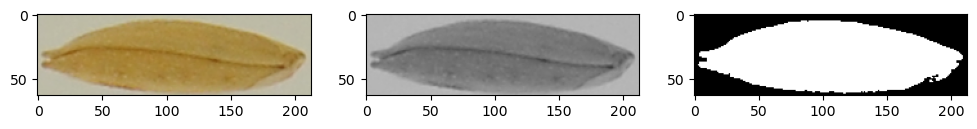

In [15]:
img_path = '/home/duyle/Downloads/Rice_photos/BC-15/BC-15/DSC6771_idx1.png'
image = cv2.imread(img_path)
gray_img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
image2 = cv2.imread(img_path)
_, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
figs,axs = plt.subplots(1,3, figsize =(12,4))

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


axs[0].imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
axs[1].imshow(cv2.cvtColor(gray_img,cv2.COLOR_RGB2BGR))
axs[2].imshow(cv2.cvtColor(binary,cv2.COLOR_RGB2BGR))

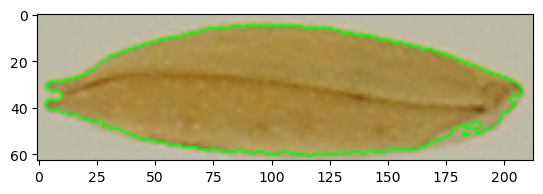

In [31]:
output_image = image.copy()
valid_contours = [contour for contour in contours if cv2.contourArea(contour) > 500]

cv2.drawContours(output_image, contours, -1, (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

3
206


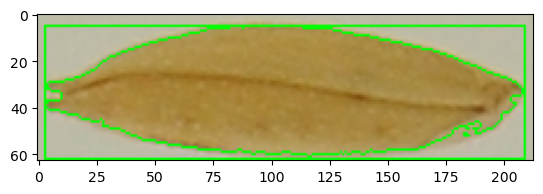

In [39]:
for contour in contours:
    x, y, width, height = cv2.boundingRect(contour)
    print(max(height,width))   
    if width > 5 and height > 5:
        cv2.rectangle(output_image, (x, y), (x + width, y + height), (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))


((105.66117858886719, 32.6317138671875), (204.6141357421875, 55.82655715942383), 2.385944128036499)


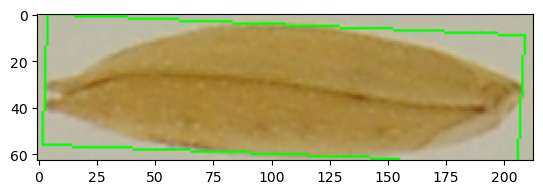

In [40]:
output_2 = image.copy()
for contour in valid_contours:
    min_rect = cv2.minAreaRect(contour)  
    box = cv2.boxPoints(min_rect)      
    box = np.int32(box)        
    print(min_rect)
    cv2.drawContours(output_2, [box], 0, (0, 255, 0), 1)  # Green rectangle
plt.imshow(cv2.cvtColor(output_2, cv2.COLOR_BGR2RGB))

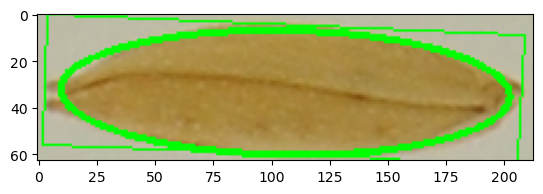

In [43]:
ellipse = cv2.fitEllipse(contour)
cv2.ellipse(output_2, ellipse, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(output_2, cv2.COLOR_BGR2RGB))

In [76]:
def extract_basic_features(image_path):
    image = cv2.imread(image_path)
    gray_img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #image2 = cv2.imread(img_path)

    _, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = [contour for contour in contours if cv2.contourArea(contour) > 1000]
    if len(valid_contours) == 0:
        return []
    
    contour = max(valid_contours, key = cv2.contourArea)
    features = []
    
    #Color
    mean_r = np.mean(image[:,:,2])
    mean_g = np.mean(image[:,:,1])
    mean_b = np.mean(image[:,:,0])

    red_sqr = np.sqrt(mean_r)
    green_sqr = np.sqrt(mean_g)
    blue_sqr = np.sqrt(mean_b)

    #Texture

    hist = cv2.calcHist([gray_img],[0],None, [256], [0,256])
    hist = hist/hist.sum()

    intensities = np.arange(256)
    mean = np.sum(intensities * hist.flatten())
    std = np.sqrt(np.sum((intensities-mean)**2 *hist.flatten()))
    uniformity = np.sum(hist.flatten()**2)
    third_moment = np.sum((intensities-mean)**3 * hist.flatten())


    #Morphological descriptors

    area = cv2.contourArea(contour)
    
    min_rect = cv2.minAreaRect(contour)
    length = max(min_rect[1])
    width = min(min_rect[1])

    ratioLW = length/width

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    hull_perimeter = cv2.arcLength(hull,True)

    ellipse = cv2.fitEllipse(contour)
    major_axis_length = max(ellipse[1])
    minor_axis_length = min(ellipse[0])




    features.append({
        "area": area,
        "length": length,
        "width": width,
        "aspect_ratio": ratioLW,
        "major_axis_length": major_axis_length,
        "minor_axis_length": minor_axis_length,
        "convex_hull_area": hull_area,
        "convex_hull_perimeter": hull_perimeter,
        "mean_r": mean_r,
        "mean_g": mean_g,
        "mean_b": mean_b,
        "red_sqr": red_sqr,
        "green_sqr": green_sqr,
        "blue_sqr": blue_sqr,
        "texture_mean": mean,
        "texture_std": std,
        "texture_uniformity": uniformity,
        "texture_third_moment": third_moment
    })
    return features

In [77]:
def process_directory(base_path):
    data = []

    for root, dirs, files in os.walk(base_path):
        if 'Negative' in root:
            continue
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                print(image_path)
                features = extract_basic_features(image_path)
                for feature in features:
                    print(feature)
                    data.append(feature)

    return pd.DataFrame(data)

In [78]:
base_path = '/home/duyle/Downloads/Rice_photos/BC-15'
df = process_directory(base_path)

/home/duyle/Downloads/Rice_photos/BC-15/BC-15/DSC7432_idx30.png
{'area': 7741.5, 'length': 213.0, 'width': 52.0, 'aspect_ratio': 4.096153846153846, 'major_axis_length': 198.32876586914062, 'minor_axis_length': 30.706851959228516, 'convex_hull_area': 8037.0, 'convex_hull_perimeter': 450.0041071176529, 'mean_r': np.float64(169.26835498467378), 'mean_g': np.float64(147.4172383593636), 'mean_b': np.float64(98.84418333090059), 'red_sqr': np.float64(13.010317251499817), 'green_sqr': np.float64(12.14155008058541), 'blue_sqr': np.float64(9.942041205451755), 'texture_mean': np.float64(135.39942953712307), 'texture_std': np.float64(32.68012721849141), 'texture_uniformity': np.float32(0.039984), 'texture_third_moment': np.float64(7844.419683392682)}
/home/duyle/Downloads/Rice_photos/BC-15/BC-15/DSC7427_idx58.png
{'area': 9043.0, 'length': 205.03042602539062, 'width': 61.82135772705078, 'aspect_ratio': 3.316498271206308, 'major_axis_length': 193.31204223632812, 'minor_axis_length': 35.479988098144

In [79]:
df.to_csv('dog.csv')